In [106]:
import pandas as pd
import numpy as np
import os

In [107]:
with open("sent_corpus.csv", "r") as sent_file:
    lines = sent_file.read().split("\n")

In [60]:
%time rows = [line.split(",") for line in lines if line]
%time rows = [row[:3] + [",".join(row[3:])] for row in rows]
# remove document start character 
rows[0][0] = rows[0][0][1:]

sentDf_cols = ['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText']


%time sentDf = pd.DataFrame(rows[1:],columns=sentDf_cols)

print(sentDf.columns.values)

sentDf[["ItemID","Sentiment"]] = sentDf[["ItemID","Sentiment"]].astype(int)
%time sentDf["SentimentText"] = sentDf["SentimentText"].apply(lambda text: text.split())

CPU times: user 2.75 s, sys: 161 ms, total: 2.91 s
Wall time: 2.96 s
CPU times: user 3.95 s, sys: 116 ms, total: 4.06 s
Wall time: 4.12 s
CPU times: user 313 ms, sys: 44.1 ms, total: 357 ms
Wall time: 359 ms
['ItemID' 'Sentiment' 'SentimentSource' 'SentimentText']
CPU times: user 4.28 s, sys: 286 ms, total: 4.57 s
Wall time: 4.7 s


In [128]:
## -*- coding: utf-8 -*-

curdir = os.getcwd()
tweet_path = curdir + "/crawler_v1/code/tweettext.txt"
print(tweet_path)

tweets = []
tweet_file = open(tweet_path, "rb")
%time 
for line in tweet_file:
#    print(line)
#    line = line_pre.decode('utf-8')
    tweet = ""
    if(line[:2] == "RT"):
        char_loc = 0
        for char in line:
            char_loc += 1
            if(char==":"):
                break

        tweet = line[-(len(line)-char_loc):]
    else:
        tweet = line
    tweets.append(tweet)

#[tweet.decode('utf-8') for tweet in tweets]
print(tweets)

print("done")

/Users/Jonny/Documents/UCLA/CS145/cs145_project/crawler_v1/code/tweettext.txt
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
['I hate it when someone posts really inspiring art or something and all people comment is \xe2\x80\x9cdeep\xe2\x80\x9d... like... that\xe2\x80\x99s a\xe2\x80\xa6 https://t.co/7pdNLhZaOw\n', 'I hate it when some dumb broad starts whining about men who nut too fast....\n', '"It was a race... You lost, bitch!"\n', 'I hate people on twitter who complain about what girls do, but they are the same people who complain about other pe\xe2\x80\xa6 https://t.co/Jtajyid1Fw\n', ' Haters don\xe2\x80\x99t hate us, they hate themselves. \n', 'Because we are a reflection of what they wish to be.\n', " I fuckin hate it when people call Harry a womanizer yall know how much he hates it he even said he doesn't like to be ca\xe2\x80\xa6\n", ' When people get hurt, they learn to hate.\n', '#ALDUBHeartsNeverApart\n', ' Do the 2016 Hate Crime statistics include the hoax

In [62]:
import gensim
%time w2vM = gensim.models.Word2Vec(sentDf["SentimentText"])


CPU times: user 5min 15s, sys: 9.69 s, total: 5min 24s
Wall time: 2min 18s


In [129]:
%time w2vM_tweets = gensim.models.Word2Vec(tweets)



CPU times: user 7.09 ms, sys: 2.44 ms, total: 9.54 ms
Wall time: 7.96 ms


In [130]:
# number of samples to aggregate
Ns = int(1e5)

In [131]:

%time
# MEAN AGGREGATION
tvecs = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in sentDf["SentimentText"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])

print(tvecs[:N])
print("prediction vecs...")

tvecs_predict = np.array([np.array([w2vM_tweets[t] if t in w2vM_tweets
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in tweets[:Ns]])

print(tvecs_predict[:N])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
[[-1.25122161 -1.11044443  0.86313852 ...,  0.00723968 -1.61906987
  -0.65277823]
 [ 0.07091121 -0.53514856 -0.45551857 ...,  0.74050069 -0.77201968
  -1.47878969]
 [-0.89652032 -0.78174579  1.4180578  ..., -1.15360987 -1.25980675
   0.88829136]
 ..., 
 [-0.93792191 -0.50204525  0.58469262 ..., -0.46476021 -1.48402048
   0.43957306]
 [-0.98003064 -0.72800219 -0.62643303 ...,  0.55065257 -0.61133645
  -0.41924939]
 [ 0.79247589 -0.00276681  0.24994299 ..., -1.21677215 -0.60112918
   0.52619559]]
prediction vecs...
[[ 0.00734437  0.01273471  0.04038044 ...,  0.00470354 -0.02957127
   0.00684811]
 [ 0.00744533  0.01343329  0.04439545 ...,  0.00479849 -0.03262145
   0.0077941 ]
 [ 0.00639241  0.01208521  0.03892023 ...,  0.00487771 -0.02856221
   0.00628329]
 ..., 
 [ 0.00704079  0.01217412  0.03864871 ...,  0.00415785 -0.02874432
   0.0064466 ]
 [ 0.00694884  0.01263509  0.03987265 ...,  0.00454965 -0.02902665
   0.006907

In [66]:
# number of samples to train on
N = int(1e5)
X = tvecs[:N]
y = sentDf["Sentiment"][:N].values
# inverse classifier
# y = 1 - y

In [67]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(N) < ratio
pidx = ~tidx

In [68]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

In [69]:
def roc_auc(clf,X,y):
    probs = clf.predict_proba(X[pidx])
    fpr, tpr, thresholds = roc_curve(y[pidx], probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

In [70]:
def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

In [71]:
def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

CPU times: user 3.56 s, sys: 69.3 ms, total: 3.63 s
Wall time: 3.7 s
TEST
('Accuracy', 0.66843953838434522, 'Precision', 0.66637980493402182, 'Recall', 0.82610241820768138, 'F1', 0.73769450619244215)
CPU times: user 26.8 ms, sys: 11.8 ms, total: 38.6 ms
Wall time: 36.7 ms
TRAIN
('Accuracy', 0.67564630947920568, 'Precision', 0.67213525360050097, 'Recall', 0.83091520325562884, 'F1', 0.7431385930035902)
CPU times: user 98.5 ms, sys: 23.1 ms, total: 122 ms
Wall time: 117 ms
ROC AUC


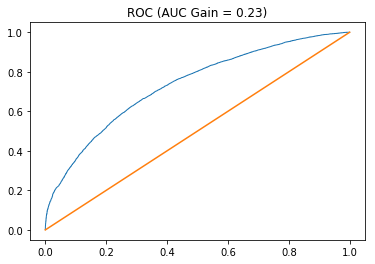

CPU times: user 214 ms, sys: 16.2 ms, total: 230 ms
Wall time: 236 ms
PRECISION/RECALL AUC


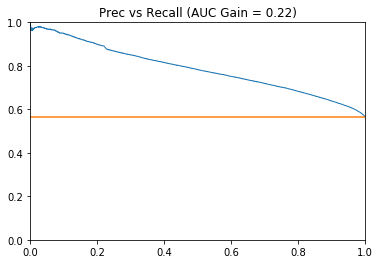

CPU times: user 377 ms, sys: 42.7 ms, total: 420 ms
Wall time: 425 ms


In [114]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
#clf = rf
%time rf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(rf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(rf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(rf,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(rf,X,y)

CPU times: user 1min 30s, sys: 3.32 s, total: 1min 33s
Wall time: 52.7 s
TEST
('Accuracy', 0.74004014049172107, 'Precision', 0.77909651301867699, 'Recall', 0.75284495021337128, 'F1', 0.76574580639327217)
CPU times: user 36.8 ms, sys: 16.9 ms, total: 53.6 ms
Wall time: 35.3 ms
TRAIN
('Accuracy', 0.81651055326589239, 'Precision', 0.85168456468636222, 'Recall', 0.81740168974211524, 'F1', 0.83419104369808594)
CPU times: user 250 ms, sys: 56.1 ms, total: 306 ms
Wall time: 202 ms
ROC AUC


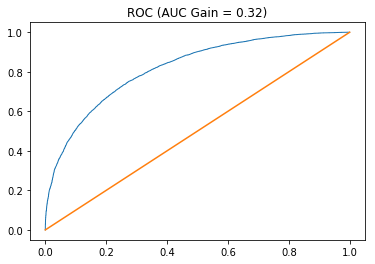

CPU times: user 193 ms, sys: 42.3 ms, total: 235 ms
Wall time: 216 ms
PRECISION/RECALL AUC


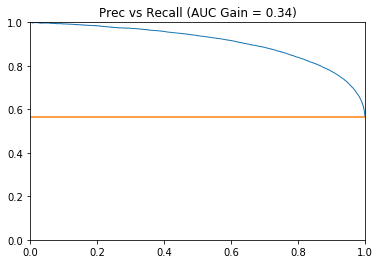

CPU times: user 449 ms, sys: 66.2 ms, total: 515 ms
Wall time: 400 ms


In [73]:
mlp = sklearn.neural_network.MLPClassifier()
clf_nn = mlp
%time clf_nn.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf_nn,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf_nn,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf_nn,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(clf_nn,X,y)

CPU times: user 2.59 s, sys: 219 ms, total: 2.81 s
Wall time: 2.33 s
TEST
Accuracy 0.71173456698 Precision 0.760003838403 Recall 0.706260032103 F1 0.732146984054
CPU times: user 118 ms, sys: 90.6 ms, total: 209 ms
Wall time: 216 ms
TRAIN
Accuracy 0.719376196853 Precision 0.769485042382 Recall 0.720252828854 F1 0.744055433157
CPU times: user 437 ms, sys: 250 ms, total: 687 ms
Wall time: 693 ms
ROC AUC


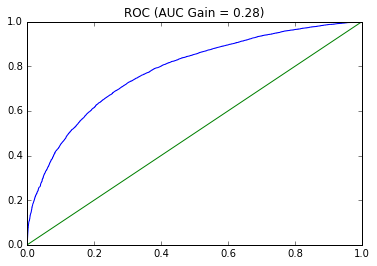

CPU times: user 345 ms, sys: 101 ms, total: 446 ms
Wall time: 469 ms
PRECISION/RECALL AUC


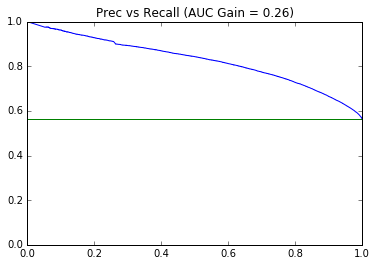

CPU times: user 752 ms, sys: 282 ms, total: 1.03 s
Wall time: 827 ms


In [17]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X,y)

In [138]:

#X = tweets
%time prediction = clf_nn.predict(tvecs_predict[:N])

mean = reduce(lambda x,y: (x+y), prediction)/float(len(prediction))

print(mean)
print("done")

CPU times: user 853 µs, sys: 200 µs, total: 1.05 ms
Wall time: 556 µs
1.0
done
